### Project is not yet fully annotated

The purpose of this project is to identify correlation between a pitchers single season statistics and his pay. The queries below pull pitcher pay data and pitcher statistics from 1985 to 2014 from the Lehman's data base. Two methods were used to format the salary data in a way that may be more useful for this analysis. The first compares the current salary of a player with future salary in the next season. The hope here is to identify whether a player's single season performance correlates with an increase in his pay. However, there are many factors that could alter this correlation, such as multi-season performance, contracts voiding a players chance at a raise, etc. The second salary formation method compares a pitchers salary to that of his peers and assigns his salary to a certain percentile of that year's salaries. The following study will measure the correlation between a players single season stats and his pay to determine if a relationship can be established.

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import mysql.connector as sql
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pingouin

In [2]:
#Connect to Lehmans Database
db_connection = sql.connect(host='localhost', database='Lehmans2014', 
user='root', password='Se@lBe@ch1922') #password censored

In [3]:
#what is the following query doing?

In [4]:
#Create table with salary of year & previous year
query1 = '''
#Select year and previous year and salaries for pitchers only
SELECT 
    p.playerID AS playerID,
    s.yearID AS prev_year,
    s2.yearID AS yearID,
    s.salary AS prev_salary,
    s2.salary AS salary
FROM
    Salaries s
        JOIN
    (#Select Pitchers only
		SELECT DISTINCT
			(sx.playerID), 1 AS pitcher
		FROM
			Pitching px
		JOIN Salaries sx ON sx.playerID = px.playerID) p 
    ON s.playerID = p.playerID
	JOIN #collect the next years data
		Salaries s2 
        ON (s.playerID = s2.playerID)
			AND (s.yearID = (s2.yearID - 1));  
'''
#Query Lehman's DB with query1 & store in sal_change dataframe
salary = pd.read_sql(query1, con=db_connection)

print('Number of entries: ',len(salary))
salary.head()

/Users/bmcgee1/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Number of entries:  9080


,playerID,prev_year,yearID,prev_salary,salary
0,ackerji01,1985,1986,170000,367500
1,barkele01,1985,1986,870000,880000
2,campri01,1985,1986,633333,600000
3,dedmoje01,1985,1986,150000,200000
4,garbege01,1985,1986,772000,786667


In [5]:
#describe percent difference calculation

In [6]:
#Calculate percent change in salary between years
def percent_change(df):
    return round((df.salary-df.prev_salary)/df.prev_salary*100,2)

salary['perc_diff'] = salary.apply(percent_change, axis=1)
salary.head()

,playerID,prev_year,yearID,prev_salary,salary,perc_diff
0,ackerji01,1985,1986,170000,367500,116.18
1,barkele01,1985,1986,870000,880000,1.15
2,campri01,1985,1986,633333,600000,-5.26
3,dedmoje01,1985,1986,150000,200000,33.33
4,garbege01,1985,1986,772000,786667,1.90


In [7]:
#describe percentile calculations

In [8]:
'''Calculate Percentiles'''
#numerator = (# of salaries < current salary)
#denominator = (total number of salaries that year)
#percentile = numerator/denominator*100
for i in range(len(salary)):
    #select year
    year = salary.loc[i,'yearID']
    
    #select salary
    sal = salary.loc[i,'salary']
    
    #calculate numerator
    numerator = sum((salary.salary<sal)&(salary.yearID==year))
    
    #calculate denominator
    denominator = sum(salary.yearID==year)
    
    #calculate percentile
    salary.loc[i,'percentile'] = round(numerator/denominator*100,2)

salary.head()

,playerID,prev_year,yearID,prev_salary,salary,perc_diff,percentile
0,ackerji01,1985,1986,170000,367500,116.18,33.18
1,barkele01,1985,1986,870000,880000,1.15,81.36
2,campri01,1985,1986,633333,600000,-5.26,57.27
3,dedmoje01,1985,1986,150000,200000,33.33,11.82
4,garbege01,1985,1986,772000,786667,1.90,75.45


In [9]:
#intro the following display

Descriptive Statistics of Percent Changes in Salary
count    9080.000000
mean       59.746849
std       133.263719
min      -100.000000
25%         3.120000
50%        24.635000
75%        69.440000
max      2958.100000
Name: perc_diff, dtype: float64


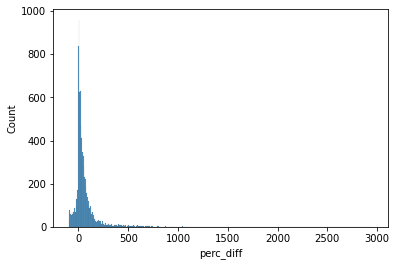

In [10]:
#Show description of variable
print('Descriptive Statistics of Percent Changes in Salary')
print(salary.perc_diff.describe())

#Display distribution of salary changes
sns.histplot(data=salary, x='perc_diff');

In [11]:
#what did we learn from the above display

#Talk about below 2 cells

In [12]:
#Use only changes greater than average
avg_perc_diff = round(salary.perc_diff.mean())
print('On average pitcher salaries increase by ',avg_perc_diff,'%')

On average pitcher salaries increase by  60 %


In [118]:
#Excluding Players who stopped playing & whose salary did not change
salary = salary.loc[(salary['perc_diff']!=0)&(salary['perc_diff']>-100)].copy()
salary.sort_values(by=['perc_diff'],
                         inplace=True,ignore_index=True)
print('<<<<<<<<<<<<<<<<<<<<< Salary Total >>>>>>>>>>>>>>>>>>>>>')
print(salary.head())

<<<<<<<<<<<<<<<<<<<<< Salary Total >>>>>>>>>>>>>>>>>>>>>
    playerID  prev_year  yearID  prev_salary  salary  perc_diff  percentile
0  appieke01       2003    2004     11500000  300000     -97.39        0.00
1  fernasi01       1994    1995      3333333  109000     -96.73        0.00
2  carpech02       2011    2012     14259403  482000     -96.62        2.14
3  bonilbo01       1999    2000      5900000  200000     -96.61        0.00
4  gaettga01       1993    1994      3000000  109000     -96.37        0.28


In [14]:
#talk about query and what it is doing

In [41]:
#Pull in Pitcher stats
query2='''
SELECT 
	p.*
FROM
    pitching p
        JOIN
    (#Select Pitchers only
		SELECT DISTINCT
			(sx.playerID), 1 AS pitcher
		FROM
			Pitching px
		JOIN Salaries sx ON sx.playerID = px.playerID) po 
    ON po.playerID = p.playerID
    WHERE p.yearID>=1985
    ORDER BY p.yearID, p.playerID, p.stint;
'''
#Query Lehman's DB with query2 & store in pitching dataframe
pitching = pd.read_sql(query2, con=db_connection)

print('Number of entries: ',len(pitching))
pitching.head()

Number of entries:  16613


,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,aasedo01,1985,1,BAL,AL,10,6,54,0,0,...,7,0,1,1,366,43,44,0,0,0
1,ackerji01,1985,1,TOR,AL,7,2,61,0,0,...,1,2,3,0,370,26,35,0,0,0
2,agostju01,1985,1,CHA,AL,4,3,54,0,0,...,1,0,3,0,246,21,27,0,0,0
3,aguilri01,1985,1,NYN,NL,10,7,21,19,2,...,2,5,2,2,507,1,49,0,0,0
4,alexado01,1985,1,TOR,AL,17,10,36,36,6,...,0,9,6,0,1090,0,105,0,0,0


In [42]:
#Talk about simplifying the scope here

In [43]:
'''If player played multiple stints, they are not included in the study'''
#grab the indexes of those player & year combinations that have multiple stints and drop them
mstint = []
for i in range(len(pitching)):
    s = pitching.loc[(pitching['playerID']==pitching.loc[i,'playerID'])&
                     (pitching['yearID']==pitching.loc[i,'yearID'])].stint.max()
    if s > 1:
        mstint.append(i)
for stint in mstint:
    pitching.drop(stint,inplace=True)
    
#Drop irrelevant data
pitching.drop(columns=['stint','teamID','lgID'],axis=1,inplace=True)
pitching.head()

,playerID,yearID,W,L,G,GS,CG,SHO,SV,IPOuts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,aasedo01,1985,10,6,54,0,0,0,14,264,...,7,0,1,1,366,43,44,0,0,0
1,ackerji01,1985,7,2,61,0,0,0,10,259,...,1,2,3,0,370,26,35,0,0,0
2,agostju01,1985,4,3,54,0,0,0,1,181,...,1,0,3,0,246,21,27,0,0,0
3,aguilri01,1985,10,7,21,19,2,0,0,367,...,2,5,2,2,507,1,49,0,0,0
4,alexado01,1985,17,10,36,36,6,1,0,782,...,0,9,6,0,1090,0,105,0,0,0


In [18]:
#describe the join below

In [19]:
#Join pitching with total salaries
temp1 = pd.merge(salary,pitching,on=['playerID','yearID'])
sal_total = temp1.drop(columns=['playerID','yearID','salary','prev_year','prev_salary'], axis=1).copy()
sal_total.head()

,perc_diff,percentile,W,L,G,GS,CG,SHO,SV,IPOuts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,-97.39,0.00,0,1,2,2,0,0,0,12,...,0,2,0,0,22,0,8,0,0,0
1,-96.62,2.14,1,0,8,0,0,0,0,18,...,2,2,0,0,34,3,6,2,0,0
2,-96.02,0.00,0,1,5,0,0,0,0,20,...,2,0,0,1,37,2,12,0,0,0
3,60.00,0.00,0,1,5,0,0,0,0,20,...,2,0,0,1,37,2,12,0,0,0
4,-96.00,0.00,3,1,63,0,0,0,6,235,...,9,0,0,1,317,35,25,0,0,0


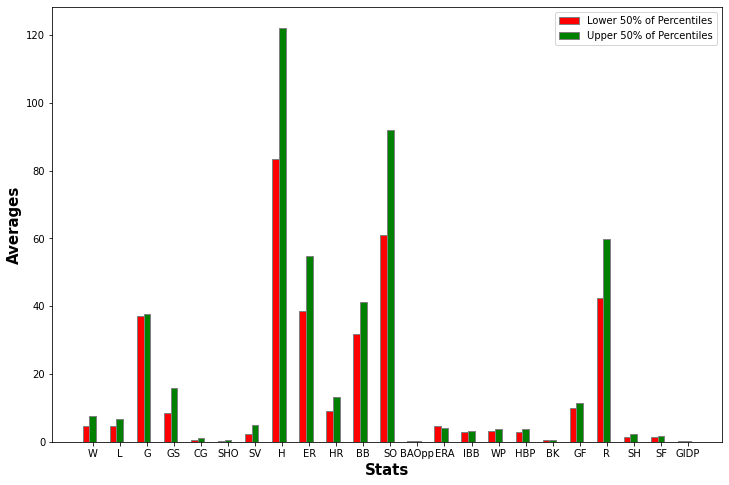

In [20]:
'''Visualize variables compared to percentile'''
#set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
#Lower Percentiles
temp = sal_total.loc[sal_total['percentile']<50]
heightsL = list(temp.drop(['perc_diff','percentile','IPOuts','BFP'],axis=1).mean())
labels = list(temp.drop(['perc_diff','percentile','IPOuts','BFP'],axis=1).columns)

#Upper Percentiles
temp2 = sal_total.loc[sal_total['percentile']>50]
heightsU = list(temp2.drop(['perc_diff','percentile','IPOuts','BFP'],axis=1).mean())
 
# Set position of bar on X axis
br1 = np.arange(len(heightsL))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, heightsL, color ='r', width = barWidth,
        edgecolor ='grey', label ='Lower 50% of Percentiles')
plt.bar(br2, heightsU, color ='g', width = barWidth,
        edgecolor ='grey', label ='Upper 50% of Percentiles')

 
# Adding Xticks
plt.xlabel('Stats', fontweight ='bold', fontsize = 15)
plt.ylabel('Averages', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(heightsL))],
        labels)
 
plt.legend();

In [21]:
#breakdown above visualization 

## Linear Regression 1 - Raw Stats

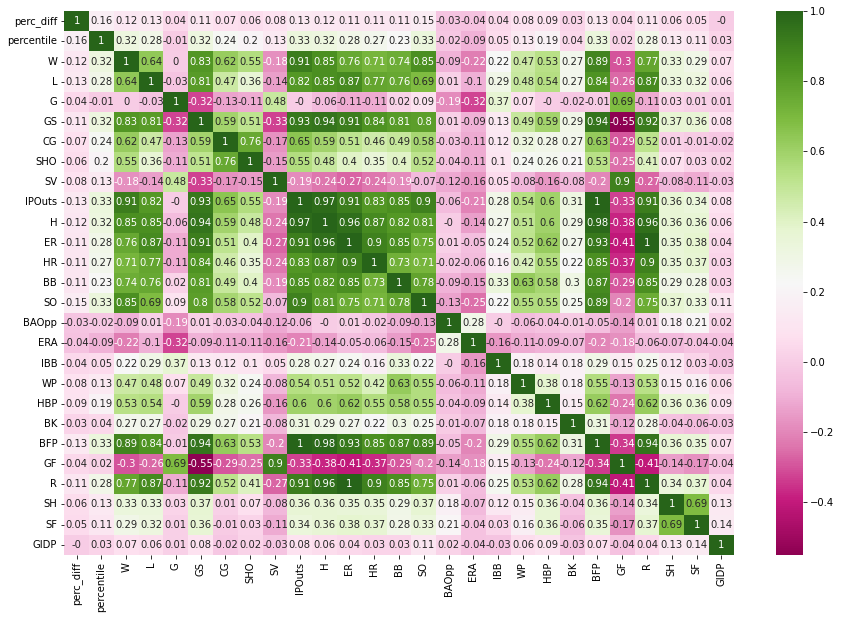

In [22]:
#Calculate correlation between variables
iv = sal_total.columns
data = round(sal_total.corr(),2)

#Visualize variables correlation
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(data, 
                 xticklabels=iv, yticklabels=iv,cmap='PiYG',annot=True)

In [23]:
#breakdown correlation visual and next steps

In [24]:
#Get Scaled version of pitching stats
scaled_innings = sal_total.drop(['perc_diff', 'percentile', 'W', 'L', 'G','GS', 
                         'ERA','BAOpp','CG', 'SHO', 'SV', 'IPOuts', 'GF'],axis=1).copy()

#Number of fields to be scaled
col = len(scaled_innings.columns)

#Number of entries
row = len(sal_total)

#Create an inverse IPOuts matrix to be multiplied to the statistics
IPOuts = np.array(sal_total.IPOuts).reshape((len(sal_total),1))
IPOuts[IPOuts==0]=1 #Cannot divide by zero
invIPOuts = 1/IPOuts
invIPOutsM = invIPOuts

#Loop to create matrix
for i in range(col-1):
    invIPOutsM = np.append(invIPOutsM,invIPOuts)

#reshape to matrix
invIPOutsM = invIPOutsM.reshape((row,col))

#grab stats
stats = np.array(scaled_innings)

#scale values & store in df
scaled_innings = pd.DataFrame(stats*invIPOutsM, columns = scaled_innings.columns)

#Add pay percentile & BAOpp
scaled_innings = scaled_innings.join(sal_total['percentile'])
scaled_innings = scaled_innings.join(sal_total['BAOpp'])
scaled_innings.head()

,H,ER,HR,BB,SO,IBB,WP,HBP,BK,BFP,R,SH,SF,GIDP,percentile,BAOpp
0,0.583333,0.333333,0.000000,0.150000,0.008511,0.000000,0.046512,0.0,0.000000,0.040665,0.347826,0.000000,0.0,0.0,0.00,0.368
1,0.018717,0.038961,0.006494,0.333333,0.066667,0.048780,0.005747,0.0,0.000000,0.259542,0.045802,0.002946,0.0,0.0,2.14,0.318
2,0.464286,0.024570,0.007143,0.021429,0.006623,0.025641,0.000000,0.0,0.002304,0.552239,0.193548,0.000000,0.0,0.0,0.00,0.410
3,0.541667,0.238095,0.005556,0.009317,0.009852,0.009434,0.000000,0.0,0.005556,1.156250,0.048387,0.000000,0.0,0.0,0.00,0.410
4,0.549296,0.056098,0.004175,0.059574,0.102210,3.000000,0.000000,0.0,0.066667,21.133333,0.172414,0.000000,0.0,0.0,0.00,0.260


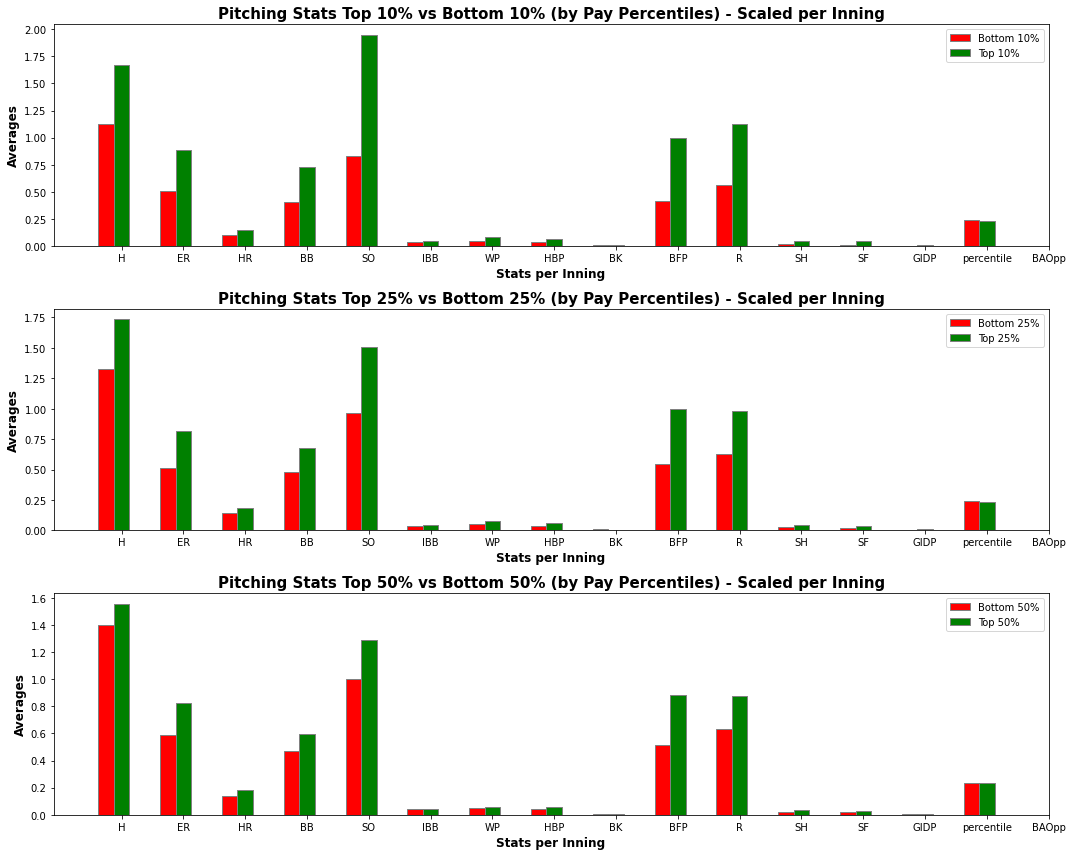

In [25]:
#Create Subplot
fig, axes = plt.subplots(3,1,figsize =(15, 12))

#Range of percentiles
split = [10,25,50]

#Drop unchanged columns & get stats names
temp = scaled_innings.copy()
temp['BFP']=temp['BFP']/10 #BFP is about 10 times larger than other stats, scaled for display
names = temp.columns

# set width of bar
barWidth = 0.25

#Set position of bar labels
x = [r + barWidth for r in range(len(names))]

for i in range(3):
    # set height of bar
    #Lower Percentiles
    temp2 = temp.loc[(sal_total['percentile']<=(split[i]))]
    heightsL = list(temp2.drop(['percentile'],axis=1).mean())
    labels = list(temp.drop(['percentile'],axis=1).columns)

    #Upper Percentiles
    temp3 = temp.loc[sal_total['percentile']>(100-split[i])]
    heightsU = list(temp3.drop(['percentile'],axis=1).mean())

    # Set position of bar on X axis
    br1 = np.arange(len(heightsL))
    br2 = [x + barWidth for x in br1]
    
    # Make the plot
    axes[i].bar(br1, heightsL, color ='r', width = barWidth,
        edgecolor ='grey', label ='Bottom '+str(split[i])+'%')
    axes[i].bar(br2, heightsU, color ='g', width = barWidth,
        edgecolor ='grey', label ='Top '+str(split[i])+'%')


    # Adding Plot Labels
    axes[i].set_title('Pitching Stats Top '+str(split[i])+'% vs Bottom '+str(split[i])+'% (by Pay Percentiles) - Scaled per Inning',
                     fontweight ='bold', fontsize = 15)
    axes[i].set_xlabel('Stats per Inning', fontweight ='bold', fontsize = 12)
    axes[i].set_ylabel('Averages', fontweight ='bold', fontsize = 12)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(names)
    
    #Improve spacing between plots
    plt.tight_layout()

    #Show Legend
    axes[i].legend();

We also want to scale a few stats on a per game basis. This helps us identify the most consistently good pitchers. The stats affected by this will be Wins (W), Losses (L), Games Started (GS), Complete Games (CG), Shutouts (SHO), Saves (SV), and Games Finished(GF).

In [27]:
#Scale per game stats
scaled_games = sal_total.drop(['perc_diff','percentile', 'G','IPOuts','H', 'ER', 'HR', 'BB', 
                               'SO', 'BAOpp', 'ERA', 'IBB', 'WP', 'HBP', 'BK',
                               'BFP', 'R', 'SH', 'SF', 'GIDP'],axis=1).copy()

#Number of fields to be scaled
col = len(scaled_games.columns)

#Number of entries
row = len(sal_total)

#Create an inverse IPOuts matrix to be multiplied to the statistics
G = np.array(sal_total.G).reshape((len(sal_total),1))
G[G==0]=1 #Cannot divide by zero
invG = 1/G
invGM = invG

#Loop to create matrix
for i in range(col-1):
    invGM = np.append(invGM,invG)

#reshape to matrix
invGM = invGM.reshape((row,col))

#grab stats
stats = np.array(scaled_games)

#scale values & store in df
scaled_games = pd.DataFrame(stats*invGM, columns = scaled_games.columns)

#Add pay percentile & BAOpp
scaled_games = scaled_games.join(sal_total['percentile'])
scaled_games.head()

,W,L,GS,CG,SHO,SV,GF,percentile
0,0.000000,0.125000,0.4,0.0,0.0,0.0,0.000000,0.00
1,0.142857,0.000000,0.0,0.0,0.0,0.0,0.130435,2.14
2,0.000000,0.020408,0.0,0.0,0.0,0.0,0.095238,0.00
3,0.000000,1.000000,0.0,0.0,0.0,0.0,0.076923,0.00
4,0.272727,0.040000,0.0,0.0,0.0,1.0,1.250000,0.00


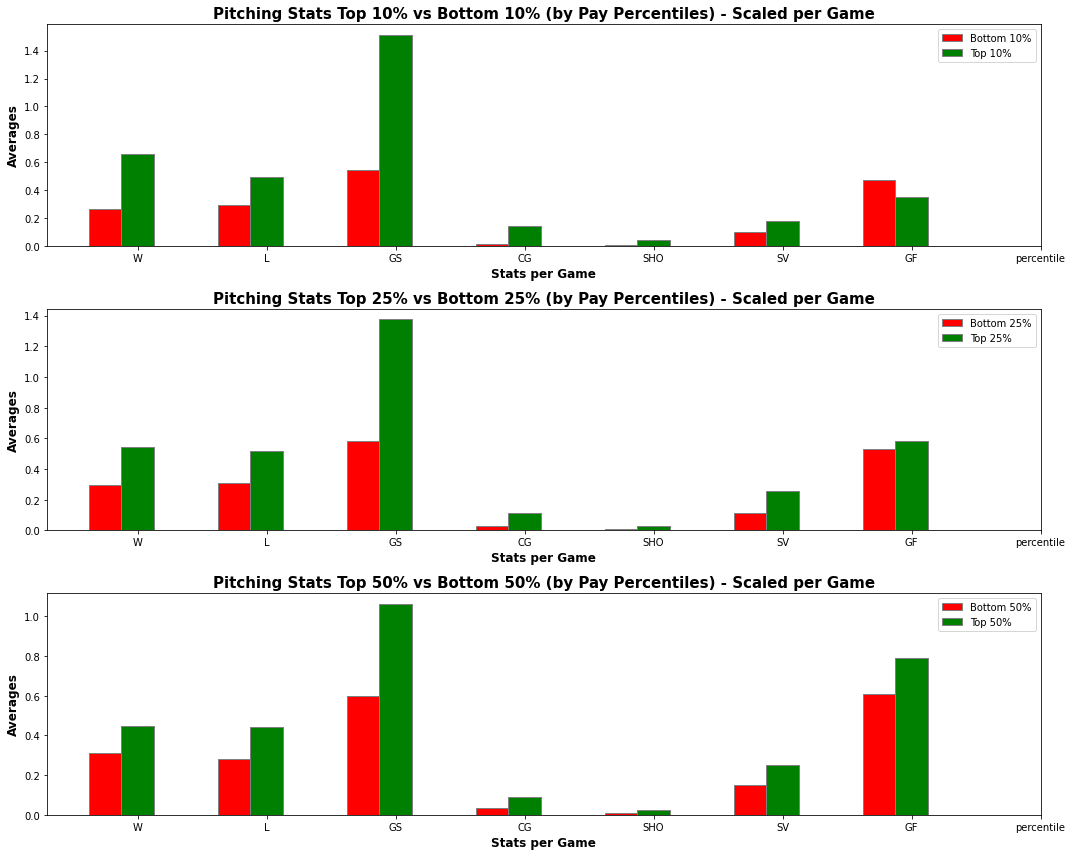

In [28]:
#Create Subplot
fig, axes = plt.subplots(3,1,figsize =(15, 12))

#Range of percentiles
split = [10,25,50]

#Copy data & get stats names
temp = scaled_games.copy()
names = temp.columns

# set width of bar
barWidth = 0.25

#Set position of bar labels
x = [r + barWidth for r in range(len(names))]

for i in range(3):
    # set height of bar
    #Lower Percentiles
    temp2 = temp.loc[(sal_total['percentile']<=(split[i]))]
    heightsL = list(temp2.drop(['percentile'],axis=1).mean())
    labels = list(temp.drop(['percentile'],axis=1).columns)

    #Upper Percentiles
    temp3 = temp.loc[sal_total['percentile']>(100-split[i])]
    heightsU = list(temp3.drop(['percentile'],axis=1).mean())

    # Set position of bar on X axis
    br1 = np.arange(len(heightsL))
    br2 = [x + barWidth for x in br1]
    
    # Make the plot
    axes[i].bar(br1, heightsL, color ='r', width = barWidth,
        edgecolor ='grey', label ='Bottom '+str(split[i])+'%')
    axes[i].bar(br2, heightsU, color ='g', width = barWidth,
        edgecolor ='grey', label ='Top '+str(split[i])+'%')


    # Adding Plot Labels
    axes[i].set_title('Pitching Stats Top '+str(split[i])+'% vs Bottom '+str(split[i])+'% (by Pay Percentiles) - Scaled per Game',
                     fontweight ='bold', fontsize = 15)
    axes[i].set_xlabel('Stats per Game', fontweight ='bold', fontsize = 12)
    axes[i].set_ylabel('Averages', fontweight ='bold', fontsize = 12)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(names)
    
    #Improve spacing between plots
    plt.tight_layout()

    #Show Legend
    axes[i].legend();

In [29]:
#breakdown what we are seeing here and next steps

In [30]:
#Scaled stats with Salary info
sal_scaled = scaled_innings.copy()
sal_scaled = sal_scaled.join(scaled_games.drop(['percentile'],axis=1))
sal_scaled = sal_scaled.join(sal_total['perc_diff'])
sal_scaled = sal_scaled.join(sal_total['ERA'])

#Reorder Columns
sal_scaled = sal_scaled[['perc_diff','percentile','ERA','H', 'ER', 'HR', 'BB', 'SO', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'R', 'SH',
       'SF', 'GIDP', 'BAOpp', 'W', 'L', 'GS', 'CG', 'SHO', 'SV',
       'GF']]

sal_scaled.head()

,perc_diff,percentile,ERA,H,ER,HR,BB,SO,IBB,WP,...,SF,GIDP,BAOpp,W,L,GS,CG,SHO,SV,GF
0,-97.39,0.00,13.50,0.583333,0.333333,0.000000,0.150000,0.008511,0.000000,0.046512,...,0.0,0.0,0.368,0.000000,0.125000,0.4,0.0,0.0,0.0,0.000000
1,-96.62,2.14,9.00,0.018717,0.038961,0.006494,0.333333,0.066667,0.048780,0.005747,...,0.0,0.0,0.318,0.142857,0.000000,0.0,0.0,0.0,0.0,0.130435
2,-96.02,0.00,13.50,0.464286,0.024570,0.007143,0.021429,0.006623,0.025641,0.000000,...,0.0,0.0,0.410,0.000000,0.020408,0.0,0.0,0.0,0.0,0.095238
3,60.00,0.00,13.50,0.541667,0.238095,0.005556,0.009317,0.009852,0.009434,0.000000,...,0.0,0.0,0.410,0.000000,1.000000,0.0,0.0,0.0,0.0,0.076923
4,-96.00,0.00,2.64,0.549296,0.056098,0.004175,0.059574,0.102210,3.000000,0.000000,...,0.0,0.0,0.260,0.272727,0.040000,0.0,0.0,0.0,1.0,1.250000


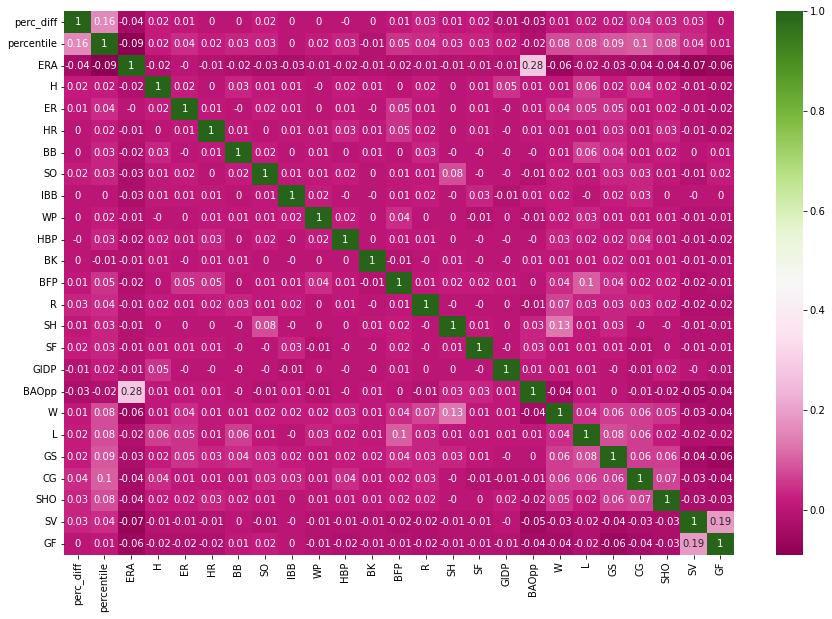

In [117]:
#Check Correlation between salary info & scaled stats
iv = sal_scaled.columns
corr_data = round(sal_scaled.corr(),2)

#Create Correlation Matrix
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_data,xticklabels=iv, yticklabels=iv,cmap='PiYG',annot=True)

In [32]:
#breakdown changes in correlation and next steps

In [33]:
iv_corr = pd.DataFrame(data,index = iv, columns=iv)
iv_corr.percentile.sort_values(ascending=False)

percentile    1.00
BFP           0.33
SO            0.33
W             0.32
H             0.32
GS            0.32
ER            0.28
L             0.28
R             0.28
HR            0.27
CG            0.24
BB            0.23
SHO           0.20
HBP           0.19
perc_diff     0.16
SH            0.13
WP            0.13
SV            0.13
SF            0.11
IBB           0.05
BK            0.04
GIDP          0.03
GF            0.02
BAOpp        -0.02
ERA          -0.09
Name: percentile, dtype: float64

In [34]:
col_drop = ['perc_diff', 'L', 'SV', 'H','SO','BFP','SHO',
            'ER', 'HR', 'BB', 'BAOpp', 'IBB', 'WP','HBP', 
            'BK', 'GF', 'R', 'SH', 'SF', 'GIDP']
refined = sal_scaled.drop(col_drop,axis=1)
refined.head()

,percentile,ERA,W,GS,CG
0,0.00,13.50,0.000000,0.4,0.0
1,2.14,9.00,0.142857,0.0,0.0
2,0.00,13.50,0.000000,0.0,0.0
3,0.00,13.50,0.000000,0.0,0.0
4,0.00,2.64,0.272727,0.0,0.0


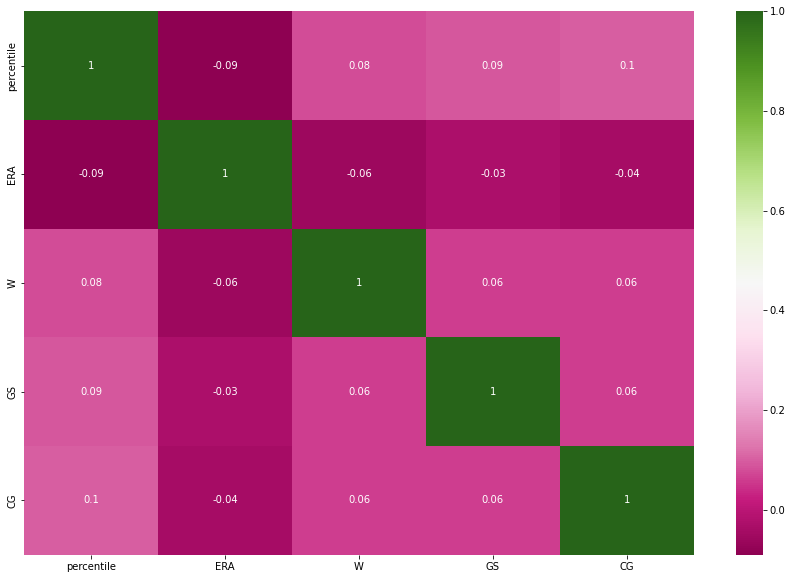

In [35]:
#Correlation data 
iv = refined.columns
data = round(refined.corr(),2)

#Visulize Correlation
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.heatmap(data,xticklabels=iv,yticklabels=iv,cmap='PiYG',annot=True)

In [36]:
#Breakdown findings and intro linear regression though expectations are not high

In [37]:
#Do linear regression & evaluate results
pingouin.linear_regression(refined.drop(columns=['percentile'],axis=1),refined['percentile'],relimp=True)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,50.662632,0.622129,81.434314,0.000000e+00,0.028667,0.028086,49.443061,51.882203,NaN,NaN
1,ERA,-0.713123,0.107248,-6.649283,3.177775e-11,0.028667,0.028086,-0.923363,-0.502883,0.007225,25.202091
2,W,1.746968,0.310151,5.632639,1.846843e-08,0.028667,0.028086,1.138973,2.354962,0.005679,19.810816
3,GS,0.750426,0.112567,6.666508,2.828614e-11,0.028667,0.028086,0.529760,0.971092,0.007416,25.870576
4,CG,7.211903,1.026612,7.024958,2.352836e-12,0.028667,0.028086,5.199418,9.224389,0.008347,29.116518


## Linear Regression 2 - Compared to the Season Average

In [159]:
#Find average stats per season
stats = ['W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPOuts',
       'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'IBB', 'WP', 'HBP', 'BK',
       'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP']
temp = pitching.drop(['playerID'],axis=1)
yearly_avg = temp.groupby('yearID').mean()
yearly_avg

,W,L,G,GS,CG,SHO,SV,IPOuts,H,ER,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
yearID,,,,,,,,,,,,,,,,,,,,,
1985,6.041009,5.791798,30.905363,11.911672,1.839117,0.482650,2.794953,313.618297,101.053628,43.924290,...,3.668770,2.977918,1.895899,0.627760,443.119874,9.577287,49.246057,0.000000,0.000000,0.000000
1986,5.739521,5.452096,30.272455,11.254491,1.631737,0.389222,2.841317,298.428144,96.092814,43.035928,...,3.332335,3.467066,2.161677,0.751497,423.194611,9.511976,47.943114,0.000000,0.000000,0.000000
1987,5.456140,5.280702,30.008772,10.795322,1.494152,0.350877,2.494152,285.921053,95.356725,44.786550,...,3.169591,3.222222,2.108187,0.909357,409.725146,9.014620,49.646199,0.000000,0.000000,0.000000
1988,5.206349,5.153439,27.735450,10.465608,1.579365,0.460317,2.679894,278.412698,88.648148,38.126984,...,3.314815,3.113757,2.232804,2.240741,391.981481,8.621693,42.420635,0.000000,0.000000,0.000000
1989,5.090909,4.780749,28.096257,9.925134,1.149733,0.360963,2.663102,265.296791,84.371658,35.703209,...,3.339572,2.954545,1.844920,0.954545,373.919786,8.687166,39.973262,0.000000,0.000000,0.000000
1990,4.755501,4.677262,27.415648,9.525672,0.990220,0.317848,2.496333,249.953545,81.305623,35.493888,...,2.968215,2.946210,1.897311,0.650367,354.975550,8.119804,39.432763,0.000000,0.000000,0.000000
1991,4.717703,4.631579,28.767943,9.418660,0.854067,0.253589,2.586124,251.086124,80.698565,35.956938,...,2.684211,3.000000,1.973684,0.504785,355.581340,8.466507,39.748804,0.000000,0.000000,0.000000
1992,5.073684,4.957895,30.997368,10.039474,1.044737,0.350000,2.710526,269.263158,86.136842,36.781579,...,3.092105,2.986842,2.278947,0.507895,379.718421,8.910526,40.536842,0.000000,0.000000,0.000000
1993,4.839161,4.696970,29.566434,9.776224,0.822844,0.221445,2.466200,253.081585,85.058275,38.655012,...,2.951049,3.053613,2.454545,0.589744,362.666667,8.135198,42.797203,0.000000,0.000000,0.000000


In [114]:
#create function to calculate percent difference
def perc_diff(x,y):
    return (x-y)/y*100

"""Loop through each player by year and compare to the yearly average"""
#get year array
years = np.arange(1985,2015)

#get all playerID's
players = list(pitching['playerID'].unique())

#list of stats
stats = ['W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPOuts', 'H', 
        'ER', 'HR', 'BB','SO', 'BAOpp', 'ERA', 'IBB', 'WP', 'HBP', 'BK', 'GF',
        'R']

#create pitching percent difference data frame
pitching_pd = pd.DataFrame(pitching[['playerID','yearID']],
                           columns=['playerID','yearID','W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPOuts', 'H', 
                                   'ER', 'HR', 'BB','SO', 'BAOpp', 'ERA', 'IBB', 'WP', 'HBP', 'GF',
                                    'R'])

#Loop
for i in range(len(pitching_pd)):
    for stat in stats:
        pitching_pd.loc[i,stat]=perc_diff(pitching.loc[i,stat],yearly_avg.loc[pitching_pd.loc[i,'yearID'],stat])
        #print(stat,', ',perc_diff(pitching.loc[i,stat],yearly_avg.loc[pitching_pd.loc[i,'yearID'],stat]))
#result
pitching_pd.head(10)

/var/folders/j5/z_252v7j3rsdl4nbzlv7zp_m0000gn/T/ipykernel_64107/3126441733.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (x-y)/y*100


,playerID,yearID,W,L,G,GS,CG,SHO,SV,IPOuts,...,BB,SO,BAOpp,ERA,IBB,WP,HBP,GF,R,BK
0,aasedo01,1985,65.535248,3.594771,74.726957,-100.000000,-100.000000,-100.000000,400.902935,-15.821238,...,-6.905521,7.186475,-2.867999,-13.349146,90.799656,-100.000000,-47.254576,348.978920,-10.652745,59.296482
1,ackerji01,1985,15.874674,-65.468410,97.376748,-100.000000,-100.000000,-100.000000,257.787810,-17.415533,...,14.373217,-32.808478,1.017282,-25.957074,-72.742906,-32.838983,58.236273,171.475626,-28.928320,-100.000000
2,agostju01,1985,-33.785901,-48.202614,74.726957,-100.000000,-100.000000,-100.000000,-64.221219,-42.286530,...,-38.823628,-37.607873,-18.409119,-17.933847,-72.742906,-100.000000,58.236273,119.268775,-45.173275,-100.000000
3,aguilri01,1985,65.535248,20.860566,-32.050628,59.507415,8.747856,-100.000000,-100.000000,17.021234,...,-1.585837,18.385062,-2.867999,-25.727839,-45.485813,67.902542,5.490849,-89.558630,-0.499648,218.592965
4,alexado01,1985,181.409922,72.657952,16.484638,202.224576,226.243568,107.189542,-100.000000,149.347697,...,78.209431,127.171335,1.017282,-20.913903,-100.000000,202.224576,216.472546,-100.000000,113.215041,-100.000000
5,anderla02,1985,-50.339426,-48.202614,84.434010,-100.000000,-100.000000,-100.000000,7.336343,-30.169890,...,-30.844101,-20.010093,4.902562,-0.970453,9.028375,-66.419492,58.236273,98.386034,-16.744603,59.296482
6,andujjo01,1985,247.624021,107.189542,22.956007,219.014831,443.739280,314.379085,-100.000000,157.956889,...,118.107065,79.177391,1.017282,-22.060078,227.085125,-32.838983,480.199667,-100.000000,129.459996,-100.000000
7,atherke01,1985,-33.785901,20.860566,81.198326,-100.000000,-100.000000,-100.000000,7.336343,0.121710,...,11.713375,23.184456,-10.638559,-1.428923,118.056750,-32.838983,-100.000000,119.268775,3.561591,-100.000000
8,balleja01,1985,-66.892950,-48.202614,-35.286312,-66.419492,-100.000000,-100.000000,-64.221219,-50.258004,...,-54.782682,-50.406258,1.017282,-20.684668,90.799656,-32.838983,-47.254576,-58.234519,-57.356992,-100.000000
9,bannifl01,1985,65.535248,141.721133,10.013269,185.434322,117.495712,107.189542,-100.000000,101.518855,...,165.984226,216.760030,1.017282,11.637476,36.285469,269.385593,110.981697,-100.000000,145.704952,-100.000000


In [139]:
#Format Data
temp = salary.drop(['prev_year','prev_salary','perc_diff','salary'],axis=1)
temp.sort_values(['yearID','playerID'],inplace=True,ignore_index=True)

#merge
combined = pd.merge(temp,pitching_pd,on=['playerID','yearID'])
combined.head()

,playerID,yearID,percentile,W,L,G,GS,CG,SHO,SV,...,BB,SO,BAOpp,ERA,IBB,WP,HBP,GF,R,BK
0,allenne01,1986,84.09,21.961398,-63.316859,-27.326674,51.050811,22.568807,413.846154,-100.000000,...,2.132454,-14.080693,-7.093185,-10.831248,-69.991015,15.371330,-7.479224,-89.486937,4.290264,-100.000000
1,andujjo01,1986,95.91,109.076682,28.390994,-7.506676,131.018888,328.990826,156.923077,-64.805058,...,50.510984,8.529651,-10.964302,-10.831248,-69.991015,-42.314335,85.041551,-78.973875,46.006370,432.270916
2,bannifl01,1986,86.36,74.230569,156.781988,-7.506676,139.904230,267.706422,156.923077,-100.000000,...,29.009415,38.676776,-3.222068,-17.367178,-100.000000,44.214162,-7.479224,-100.000000,68.950228,-100.000000
3,beattji01,1986,56.36,-100.000000,10.049423,-70.270003,-37.802607,-100.000000,-100.000000,-100.000000,...,-62.372254,-63.823450,31.617988,40.522483,-39.982031,-71.157168,38.781163,-100.000000,-41.597452,-100.000000
4,beckwjo01,1986,11.82,-100.000000,-100.000000,-50.450005,-100.000000,-100.000000,-100.000000,-100.000000,...,-83.873823,-80.404369,35.489105,60.363697,-100.000000,-100.000000,-100.000000,-57.947749,-66.627115,-100.000000


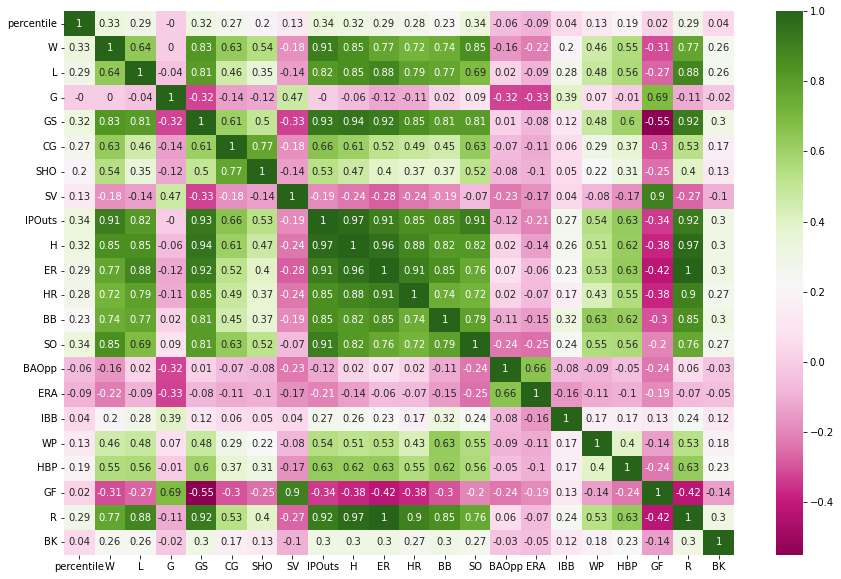

In [140]:
#Check Correlation between salary info & scaled stats
temp = combined.drop(['playerID','yearID'],axis=1)
iv = temp.columns
corr_data = round(temp.corr(),2)

#Create Correlation Matrix
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_data,xticklabels=iv, yticklabels=iv,cmap='PiYG',annot=True)

In [143]:
corr_data['percentile'].sort_values(ascending=False)

percentile    1.00
SO            0.34
IPOuts        0.34
W             0.33
H             0.32
GS            0.32
L             0.29
R             0.29
ER            0.29
HR            0.28
CG            0.27
BB            0.23
SHO           0.20
HBP           0.19
SV            0.13
WP            0.13
IBB           0.04
BK            0.04
GF            0.02
G            -0.00
BAOpp        -0.06
ERA          -0.09
Name: percentile, dtype: float64

In [148]:
#Compute VIF data for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Non-Relevant Stats
stats = ['playerID','yearID','percentile','BB','SHO','HBP','SV','WP','IBB','BK','GF','G','BAOpp','ERA']

#Create independent variable data frame
temp = combined.drop(stats,axis=1)

#VIF data frame
vif = pd.DataFrame()
vif['Stats'] = temp.columns
vif['Variable Inflation Factor'] = [variance_inflation_factor(temp.values, 
                                                              i) for i in range(temp.shape[1])]
vif.sort_values('Variable Inflation Factor',ignore_index=True)

,Stats,Variable Inflation Factor
0,CG,1.952702
1,L,5.363571
2,HR,6.393062
3,W,7.748795
4,GS,10.092328
5,SO,10.746276
6,H,69.209541
7,IPOuts,82.580144
8,ER,157.017401
9,R,169.645472


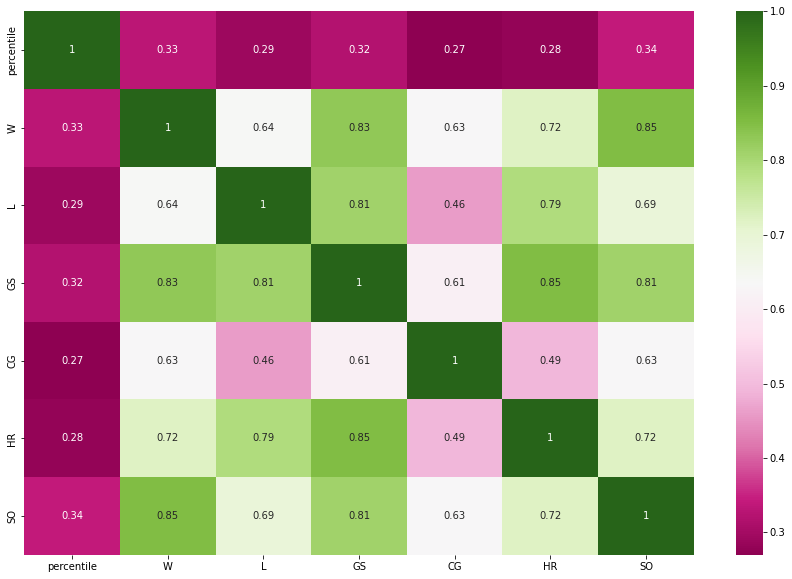

In [149]:
#Non-Relevant Stats
stats = ['playerID','yearID','BB','SHO','HBP','SV','WP','IBB','BK','GF','G','BAOpp','ERA',
        'H','IPOuts','ER','R']

#Create corr data
temp = combined.drop(stats,axis=1)
iv = temp.columns
corr_data = round(temp.corr(),2)

#Create Correlation Matrix
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_data,xticklabels=iv, yticklabels=iv,cmap='PiYG',annot=True)

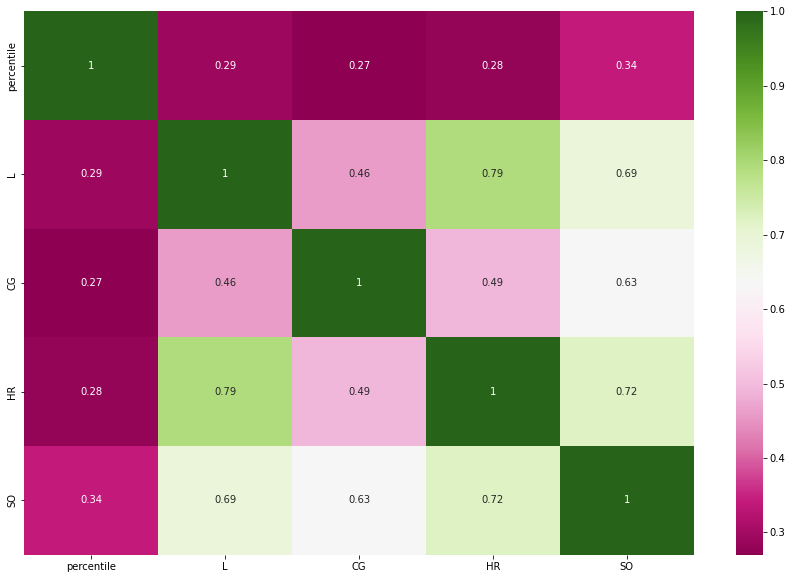

In [155]:
#Non-Relevant Stats
stats = ['playerID','yearID','BB','SHO','HBP','SV','WP','IBB','BK','GF','G','BAOpp','ERA',
        'H','IPOuts','ER','R','W','GS']
#Create corr data
temp = combined.drop(stats,axis=1)
iv = temp.columns
corr_data = round(temp.corr(),2)

#Create Correlation Matrix
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_data,xticklabels=iv, yticklabels=iv,cmap='PiYG',annot=True)

In [157]:
#Non-Relevant Stats
stats = ['playerID','yearID','percentile','BB','SHO','HBP','SV','WP','IBB','BK','GF','G','BAOpp','ERA',
        'H','IPOuts','ER','R','W','GS']

#Create corr data
temp = combined.drop(stats,axis=1)

#Do linear regression & evaluate results
pingouin.linear_regression(temp,combined['percentile'],relimp=True)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,45.553610,0.351585,129.566368,0.000000e+00,0.124344,0.12382,44.864391,46.242829,NaN,NaN
1,L,0.026352,0.005731,4.598128,4.341433e-06,0.124344,0.12382,0.015118,0.037587,0.026744,21.507892
2,CG,0.007287,0.001225,5.946942,2.869697e-09,0.124344,0.12382,0.004885,0.009689,0.025917,20.842934
3,HR,0.004508,0.005832,0.773114,4.394821e-01,0.124344,0.12382,-0.006923,0.015940,0.023199,18.657387
4,SO,0.061817,0.005624,10.991516,7.260942e-28,0.124344,0.12382,0.050792,0.072842,0.048484,38.991787
